In [146]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from google.colab.patches import cv2_imshow as imshow
import random
import numpy as np
import math
import matplotlib.image as mpimg
import glob
from patchify import patchify, unpatchify
from google.colab import drive
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Flatten, Dense, Input, MaxPooling2D, Add, Reshape, concatenate, AveragePooling2D, Multiply, GlobalAveragePooling2D, UpSampling2D, MaxPool2D,Softmax
from tensorflow.keras.activations import softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
import skimage.color
import skimage.io
import imageio as iio
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from PIL import Image
%load_ext tensorboard

drive.mount('/content/gdrive')

def add_gaussian_blur(data):
  dst = cv2.GaussianBlur(data, (35, 35), cv2.BORDER_DEFAULT)
  return dst

def add_gaussian_noise(data):
  mean = (10, 10, 10)
  std = (50, 50, 50)
  row, col, channel = data.shape
  noise = np.random.normal(mean, std, (row, col, channel)).astype('uint8')
  return data + noise
def patches(img,patch_size):
  patches = patchify(img, (patch_size, patch_size, 3), step=patch_size)
  return patches

# adds salt and pepper noise 
def add_salt_pepper_noise(data, p=0.05):
  rows, columns, channels = data.shape
  output = np.zeros(data.shape, np.uint8)
  for i in range(rows):
    for j in range(columns):
      r = np.random.random()
      if r < p/2:
        output[i][j] = [0, 0, 0]
      elif r > p/2 and r <= p:
        output[i][j] = [255, 255, 255]
      else:
        output[i][j] = data[i][j]
  return output

def load_images_from_folder(folder):
    images = []
    sizes=[]
    fname=[]
    for filename in os.listdir(folder):
        fname.append(filename)
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            sizes.append(img.shape)
    return fname,images,sizes


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [101]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [141]:
dir = os.listdir("/content/train")
folders=[]
for folder in dir:
  folders.append(folder)
files=Path('/content/train/').glob('*')
cv_img = []
f,k,s= load_images_from_folder('/content/train/')
df = pd.DataFrame()
df['filename']=f[:200]
noised_data=[]

df['ground_truth']=k
for i in k:
  g=add_gaussian_blur(i)
  n=add_gaussian_noise(g)
  noised_data.append(n)

df['noised_images']=noised_data
df['size']=s
df['size'].astype(str)
df[3][2]

filename                                       ground_truth  \
0  385028.jpg  [[[72, 114, 127], [81, 123, 136], [70, 114, 12...   
1  246016.jpg  [[[157, 142, 116], [157, 142, 116], [155, 142,...   
2  159045.jpg  [[[16, 13, 9], [14, 13, 9], [15, 13, 12], [7, ...   
3  170054.jpg  [[[61, 124, 222], [56, 120, 215], [32, 95, 185...   
4   35008.jpg  [[[32, 71, 49], [31, 70, 48], [29, 71, 48], [3...   

                                       noised_images           size  
0  [[[36, 142, 175], [83, 45, 108], [27, 29, 139]...  (321, 481, 3)  
1  [[[239, 215, 194], [211, 245, 158], [244, 139,...  (481, 321, 3)  
2  [[[66, 80, 25], [27, 148, 73], [225, 1, 4], [7...  (321, 481, 3)  
3  [[[119, 201, 12], [124, 128, 197], [87, 175, 2...  (321, 481, 3)  
4  [[[28, 99, 85], [2, 135, 129], [27, 50, 130], ...  (321, 481, 3)

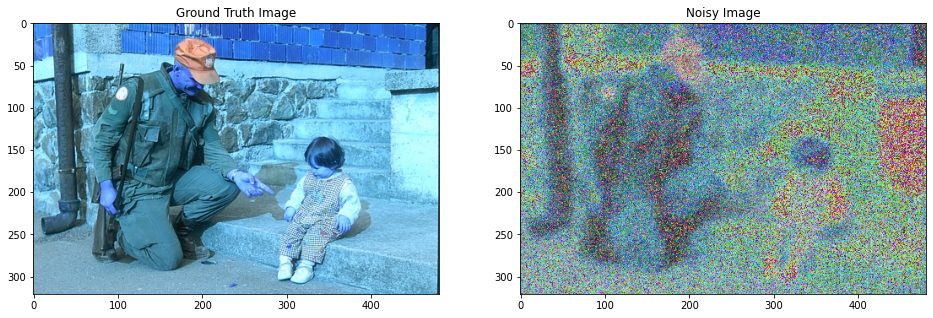

In [188]:
img = mpimg.imread('/content/train/'+df.iloc[3][0])
#p=add_gaussian_noise(img)
fig, axes = plt.subplots(1,2,figsize=(16, 16))
axes[0].imshow(df.iloc[3][1])
axes[0].set_title('Ground Truth Image')
axes[1].imshow(df.iloc[3][2])
axes[1].set_title('Noisy Image')
#imgplot = plt.imshow(df.iloc[3][2])
plt.show()

In [153]:
random_gt_path = df.iloc[3][0]
img = cv2.imread('/content/train/'+random_gt_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: {}'.format(img.shape))
patches_gt = patches(img,50)
print('Patch shape: {}'.format(patches_gt.shape))

170054.jpg
Image shape: (321, 481, 3)
Patch shape: (6, 9, 1, 50, 50, 3)


In [164]:
#Creating patches for a Noisy Image
img = df.iloc[3][2]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: {}'.format(img.shape))

patches_nsy = patches(img,50)
print('Patch shape: {}'.format(patches_nsy.shape))

Image shape: (321, 481, 3)
Patch shape: (6, 9, 1, 50, 50, 3)


In [157]:
#Creating patches for a Noisy Image
img = df.iloc[3][2]
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: {}'.format(img.shape))

patches_nsy = patches(img,50)
print('Patch shape: {}'.format(patches_nsy.shape))

Image shape: (321, 481, 3)
Patch shape: (6, 9, 1, 50, 50, 3)


In [190]:
fig = plt.figure(figsize = ( 400, 200))
df.shape
y = list(df['size'].value_counts())
print("y",y)
x1 = df['size'].value_counts().index.tolist()
x=x1[1]
x=x[:2]
print("x",x)
plt.bar(x,y)
plt.title("Images vs Size")
plt.xlabel("Size of images")
plt.ylabel("No. of images")

y [137, 63]
x (481, 321)


Text(0, 0.5, 'No. of images')

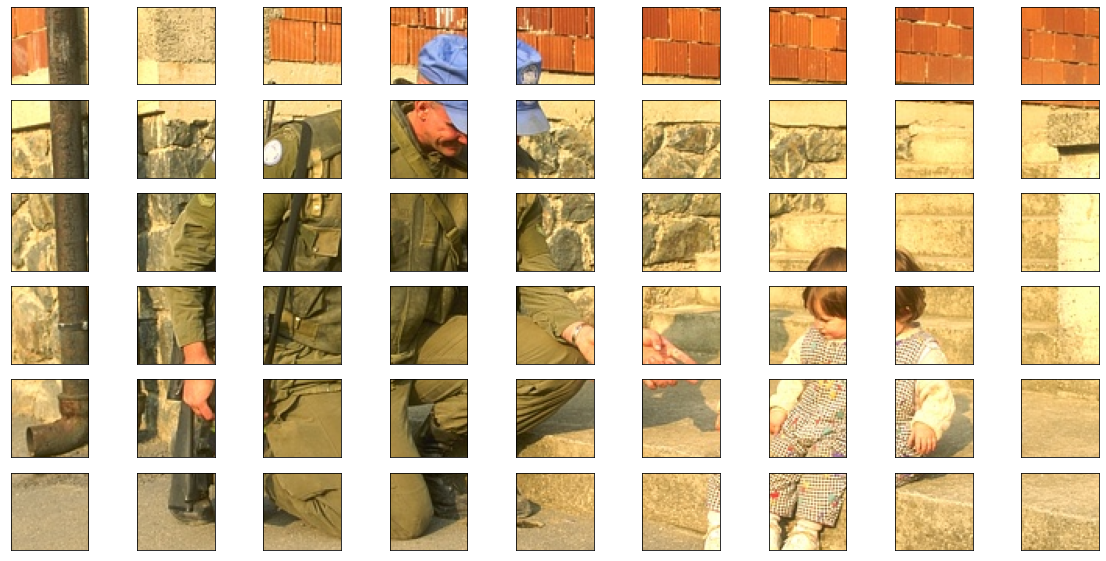

In [158]:
rows = patches_nsy.shape[0]
cols = patches_nsy.shape[1]
fig, axs = plt.subplots(rows,cols,figsize=(20,10))
for i in range(rows):
  for j in range(cols):
    axs[i][j].imshow(patches_gt[i][j][0])
    axs[i][j].get_xaxis().set_visible(False)
    axs[i][j].get_yaxis().set_visible(False)

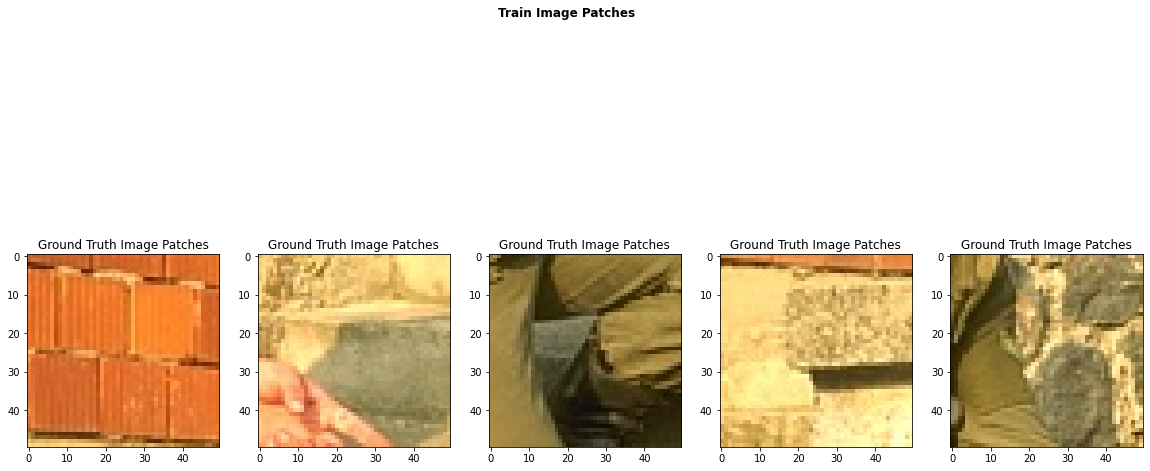

In [169]:
fig, axs = plt.subplots(1,5,figsize=(20,10))
r = random.sample(range(0, rows), 5)
c = random.sample(range(0, cols), 5)
fig.suptitle('Train Image Patches',fontweight ="bold")
for i in range(5):
  axs[i].imshow(patches_gt[r[i]][c[i]][0])
  axs[i].set_title('Ground Truth Image Patches')

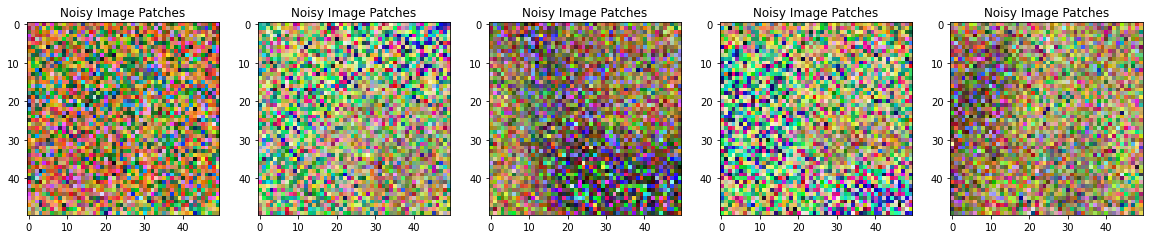

In [171]:
fig, axs = plt.subplots(1,5,figsize=(20,10))
for i in range(5):
  axs[i].imshow(patches_nsy[r[i]][c[i]][0])
  axs[i].set_title('Noisy Image Patches')

In [173]:
mean_red_gt = []
mean_blue_gt = []
mean_green_gt = []
mean_red_nsy = []
mean_blue_nsy = []
mean_green_nsy = []
for i in df['ground_truth']:
  img = i
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mean_red_gt.append(np.mean(img[:,:,0]))
  mean_green_gt.append(np.mean(img[:,:,1]))
  mean_blue_gt.append(np.mean(img[:,:,2]))

for j in df['noised_images']:
  img = j
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mean_red_nsy.append(np.mean(img[:,:,0]))
  mean_green_nsy.append(np.mean(img[:,:,1]))
  mean_blue_nsy.append(np.mean(img[:,:,2]))

In [174]:
red_gt = pd.DataFrame()
green_gt = pd.DataFrame()
blue_gt = pd.DataFrame()
red_nsy = pd.DataFrame()
green_nsy = pd.DataFrame()
blue_nsy = pd.DataFrame()

red_gt['Mean Pixel on Ground Truth Images'] = mean_red_gt
red_gt['channel'] = 'red'
red_nsy['Mean Pixel on  Noisy Images'] = mean_red_nsy
red_nsy['channel'] = 'red'

green_gt['Mean Pixel on Ground Truth Images'] = mean_green_gt
green_gt['channel'] = 'green'
green_nsy['Mean Pixel on  Noisy Images'] = mean_green_nsy
green_nsy['channel'] = 'green'

blue_gt['Mean Pixel on Ground Truth Images'] = mean_blue_gt
blue_gt['channel'] = 'blue'
blue_nsy['Mean Pixel on  Noisy Images'] = mean_blue_nsy
blue_nsy['channel'] = 'blue'

concat_gt = pd.concat([red_gt,green_gt,blue_gt],ignore_index=True)
concat_nsy = pd.concat([red_nsy,green_nsy,blue_nsy],ignore_index=True)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplo

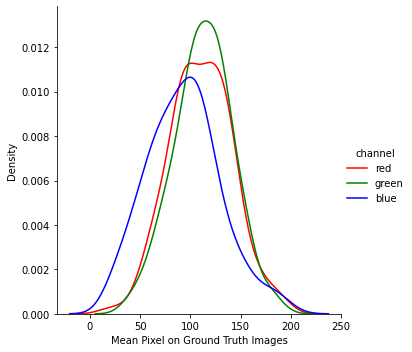

In [175]:
color = {'color': ['r', 'g', 'b']}
sns.FacetGrid(concat_gt,hue='channel',size=5,hue_kws=color).map(sns.distplot,'Mean Pixel on Ground Truth Images',hist=False).add_legend()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplo

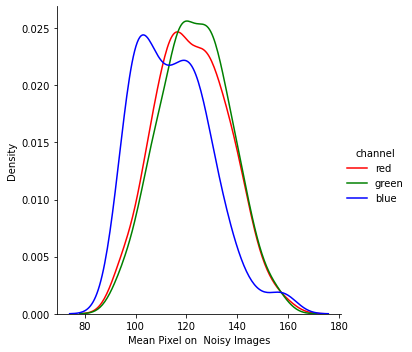

In [176]:
sns.FacetGrid(concat_nsy,hue='channel',size=5,hue_kws=color).map(sns.distplot,'Mean Pixel on  Noisy Images',hist=False).add_legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

Text(0.5, 0, 'Mean Pixels')

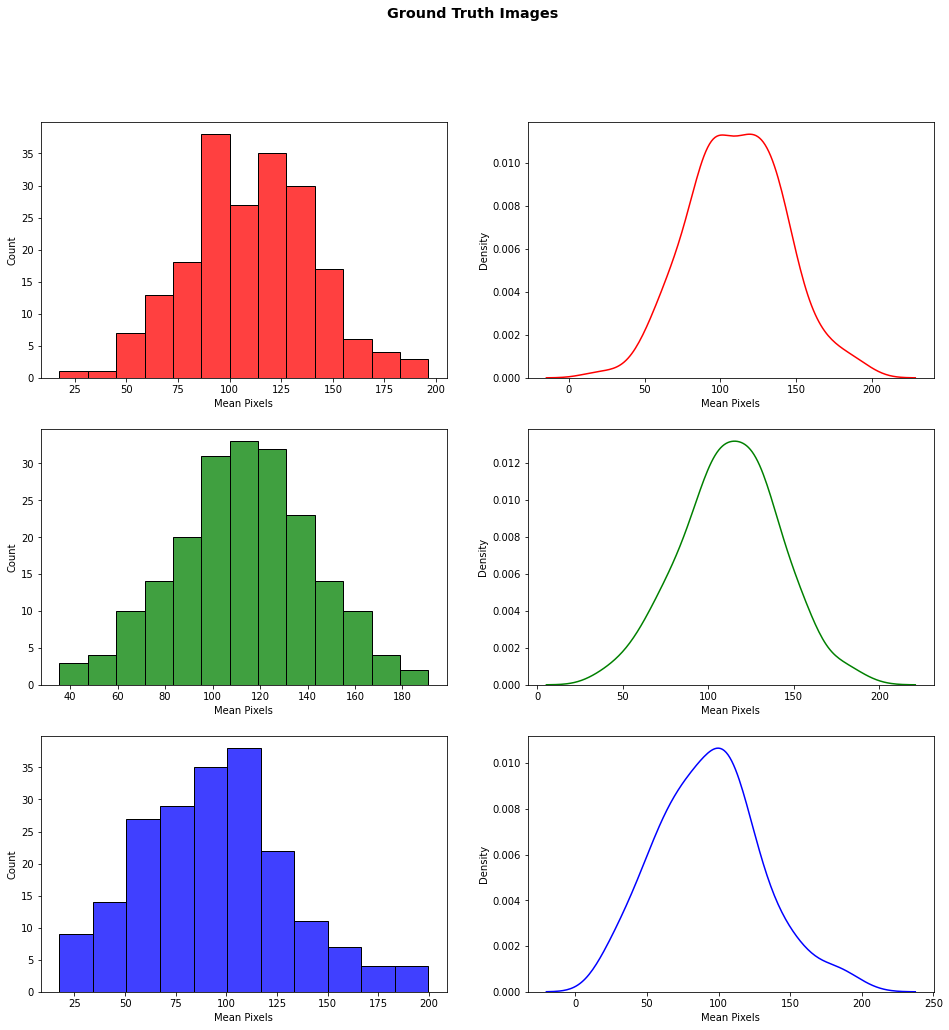

In [177]:
fig, axes = plt.subplots(3,2,figsize=(16, 16))
fig.suptitle("Ground Truth Images", fontsize = 'x-large' , fontweight = 'bold' )
sns.histplot(mean_red_gt,ax=axes[0][0],color='r')
sns.distplot(mean_red_gt,ax=axes[0][1],hist=False,color='r')
axes[0][0].set_xlabel('Mean Pixels')
axes[0][1].set_xlabel('Mean Pixels')

sns.histplot(mean_green_gt,ax=axes[1][0],color='g')
sns.distplot(mean_green_gt,ax=axes[1][1],hist=False,color='g')
axes[1][0].set_xlabel('Mean Pixels')
axes[1][1].set_xlabel('Mean Pixels')

sns.histplot(mean_blue_gt,ax=axes[2][0],color='b')
sns.distplot(mean_blue_gt,ax=axes[2][1],hist=False,color='b')
axes[2][0].set_xlabel('Mean Pixels')
axes[2][1].set_xlabel('Mean Pixels')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

Text(0.5, 0, 'Mean Pixels')

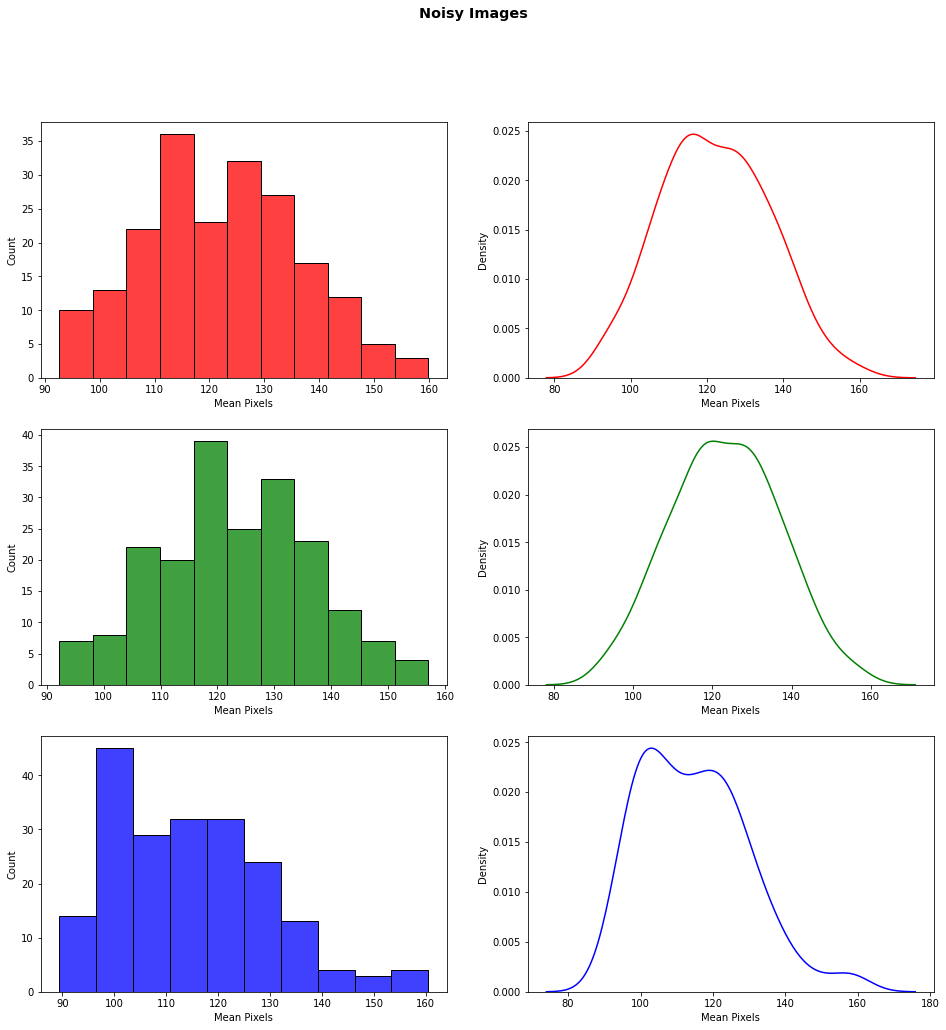

In [178]:
fig, axes = plt.subplots(3,2,figsize=(16, 16))
fig.suptitle("Noisy Images", fontsize = 'x-large' , fontweight = 'bold' )
sns.histplot(mean_red_nsy,ax=axes[0][0],color='r')
sns.distplot(mean_red_nsy,ax=axes[0][1],hist=False,color='r')
axes[0][0].set_xlabel('Mean Pixels')
axes[0][1].set_xlabel('Mean Pixels')

sns.histplot(mean_green_nsy,ax=axes[1][0],color='g')
sns.distplot(mean_green_nsy,ax=axes[1][1],hist=False,color='g')
axes[1][0].set_xlabel('Mean Pixels')
axes[1][1].set_xlabel('Mean Pixels')

sns.histplot(mean_blue_nsy,ax=axes[2][0],color='b')
sns.distplot(mean_blue_nsy,ax=axes[2][1],hist=False,color='b')
axes[2][0].set_xlabel('Mean Pixels')
axes[2][1].set_xlabel('Mean Pixels')

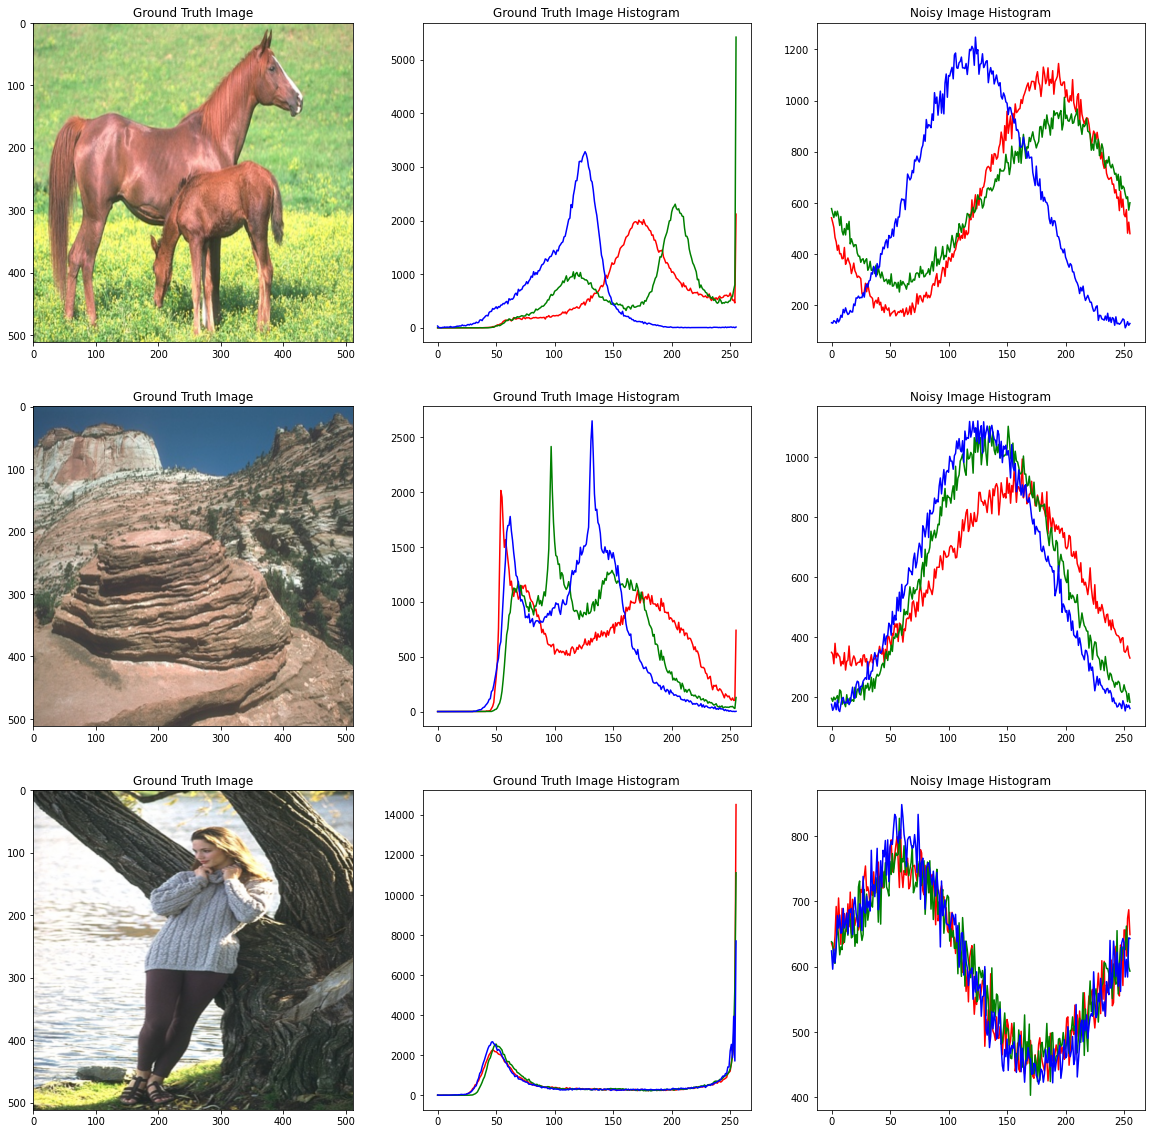

In [180]:
sample_ground_truth=[df.iloc[9][1],df.iloc[99][1],df.iloc[198][1]]
sample_noisy=[df.iloc[9][2],df.iloc[99][2],df.iloc[198][2]]
fig, axes = plt.subplots(len(sample_ground_truth),3,figsize=(20, 20))
for i in range(len(sample_ground_truth)):
  img = sample_ground_truth[i]
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  resized_img = cv2.resize(img,(512,512))
  axes[i][0].imshow(resized_img)
  axes[i][0].set_title('Ground Truth Image')
  axes[i][1].plot(cv2.calcHist([img],[0],None,[256],[0,256]),color='r')
  axes[i][1].plot(cv2.calcHist([img],[1],None,[256],[0,256]),color='g')
  axes[i][1].plot(cv2.calcHist([img],[2],None,[256],[0,256]),color='b')
  axes[i][1].set_title('Ground Truth Image Histogram')

  img = sample_noisy[i]
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axes[i][2].plot(cv2.calcHist([img],[0],None,[256],[0,256]),color='r')
  axes[i][2].plot(cv2.calcHist([img],[1],None,[256],[0,256]),color='g')
  axes[i][2].plot(cv2.calcHist([img],[2],None,[256],[0,256]),color='b')
  axes[i][2].set_title('Noisy Image Histogram')

In [181]:
from tqdm import tqdm
SSIM = [];PSNR = [];
for i in tqdm(range(len(df))):
  img1 = df.iloc[i][1]
  img1 = img1.astype("float32") / 255.0
  img2 = df.iloc[i][2]
  img2 = img2.astype("float32") / 255.0
  SSIM.append(ssim(img1,img2,multichannel=True,data_range=img2.max() - img2.min()))
  PSNR.append(psnr(img1,img2))

100%|██████████| 200/200 [00:13<00:00, 14.84it/s]


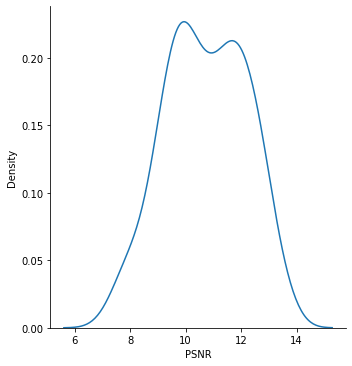

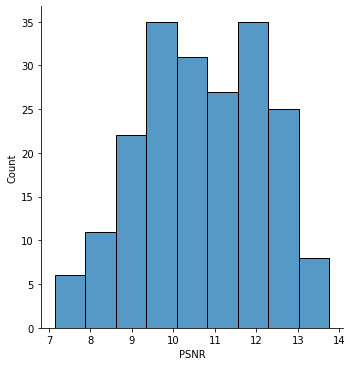

In [182]:
ax = sns.displot(PSNR,kind='kde')
ax.set(xlabel='PSNR', ylabel='Density')
ax = sns.displot(PSNR)
ax.set(xlabel='PSNR', ylabel='Count')

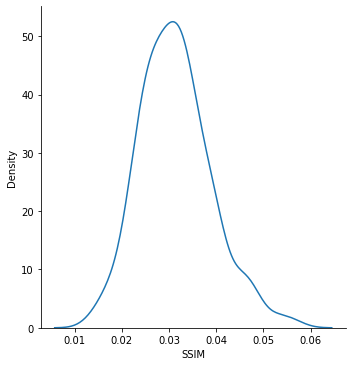

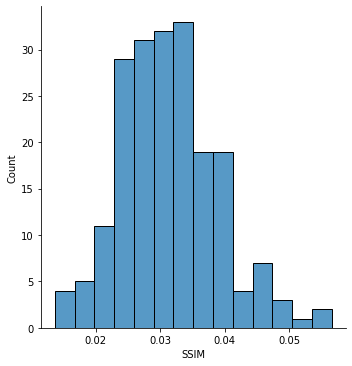

In [183]:
ax = sns.displot(SSIM,kind='kde')
ax.set(xlabel='SSIM', ylabel='Density')
ax = sns.displot(SSIM)
ax.set(xlabel='SSIM', ylabel='Count')